## Homework 4

Use this notebook as a starter

In [419]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [420]:
%pwd

'/content'

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [421]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 02:14:40--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.11’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.02s   

2021-10-03 02:14:40 (10.7 MB/s) - ‘CreditScoring.csv.11’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [422]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower().str.strip()

In [423]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [424]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [425]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [426]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [427]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [428]:
cat_list = list(df.drop(columns=['default']).select_dtypes(['object']).columns)
num_list = list(set(df.drop(columns=['default']).columns) - set(cat_list))

In [429]:
print(f'Categorical variables are : {cat_list}')
print(f'Numerical variables are : {num_list}')

Categorical variables are : ['home', 'marital', 'records', 'job']
Numerical variables are : ['income', 'seniority', 'expenses', 'time', 'age', 'debt', 'price', 'assets', 'amount']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [430]:
from sklearn .model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)




In [431]:
df_train.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [432]:
from tqdm.auto import tqdm

neg = df_train[df_train.default == 0].reset_index(drop=True)
pos = df_train[df_train.default == 1].reset_index(drop=True)

trials = 10000000
auc_scores = {}

for num in num_list:

    neg_idxs = np.random.randint(0 , len(neg) , size=trials)
    pos_idxs = np.random.randint(0 , len(pos) , size=trials)

    auc_scores[num] = (pos[num][pos_idxs].values > neg[num][neg_idxs].values).mean() 

In [433]:
auc_scores

{'age': 0.4135201,
 'amount': 0.574411,
 'assets': 0.258413,
 'debt': 0.1500384,
 'expenses': 0.4247533,
 'income': 0.3102305,
 'price': 0.503243,
 'seniority': 0.2590683,
 'time': 0.4160643}

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [434]:
auc_scores = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
auc_scores

[('amount', 0.574411),
 ('price', 0.503243),
 ('expenses', 0.4247533),
 ('time', 0.4160643),
 ('age', 0.4135201),
 ('income', 0.3102305),
 ('seniority', 0.2590683),
 ('assets', 0.258413),
 ('debt', 0.1500384)]

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [435]:
y_train = df_train.default
y_val = df_val.default
y_test = df_test.default
x_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
x_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
x_test = df_test[['seniority', 'income', 'assets', 'records', 'job', 'home']]
print(x_train['job'].value_counts())
print(x_val['job'].value_counts())
print(x_test['job'].value_counts())

fixed        1712
freelance     588
partime       254
others        117
unk             1
Name: job, dtype: int64
fixed        550
freelance    216
partime       96
others        28
unk            1
Name: job, dtype: int64
fixed        543
freelance    220
partime      102
others        26
Name: job, dtype: int64


In [436]:
# from sklearn import preprocessing

# ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
# ohe.fit(x_train)

# X_train = ohe.transform(x_train).toarray()
# X_val = ohe.transform(x_val).toarray()
# X_test = ohe.transform(x_test).toarray()


In [437]:
dicts = x_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

dicts = x_val.to_dict(orient='records')
X_val = dv.transform(dicts)

dicts = x_test.to_dict(orient='records')
X_test = dv.transform(dicts)

In [438]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [439]:
p_hat = model.predict_proba(X_val)[:,1]
y_hat = (p_hat >= 0.5).astype('uint8')
(y_val == y_hat).mean()

0.7800224466891134

In [440]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, p_hat)

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [441]:
thresholds = np.linspace(0,1,101)
recall = []
precision = []
for t in thresholds:
    y_hat = (p_hat >= t).astype('uint8')
    recall.append(y_val.dot(y_hat)/y_val.sum())
    precision.append(y_val.dot(y_hat)/y_hat.sum())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


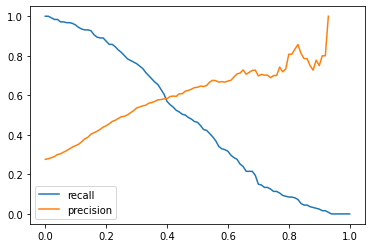

In [442]:
plt.plot(thresholds,recall , label='recall')
plt.plot(thresholds,precision , label = 'precision')
plt.legend()

In [443]:
thresholds[np.nanargmin(np.abs(np.asarray(recall) - np.asarray(precision)) )]

0.4

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [444]:
thresholds = np.linspace(0,1,101)
f1 = []
for t in thresholds:
    y_hat = (p_hat >= t).astype('uint8')
    p = y_val.dot(y_hat)/y_val.sum()
    r = y_val.dot(y_hat)/y_hat.sum()
    f1.append(2*p*r/(p+r))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [445]:
thresholds[np.nanargmax(f1)]

0.3

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [448]:
y_full_train = df_full_train.default

x_full_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]

dicts = x_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts)
dicts = x_test.to_dict(orient='records')
X_test = dv.transform(dicts)

In [451]:
y_full_train

1034    0
3955    0
398     0
3994    0
1355    1
       ..
2895    0
2763    0
905     0
3980    0
235     0
Name: default, Length: 3563, dtype: int64

In [452]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(X_full_train):
    # the k-fold split uses index to shuffle the data
    cv_train = X_full_train[train_idx]
    cv_val = X_full_train[val_idx]
    
    # y values come from dataset
    y_cv_train = y_full_train.iloc[train_idx]
    y_cv_val = y_full_train.iloc[val_idx]
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(cv_train , y_cv_train)    
    p_hat = model.predict_proba(cv_val)[:, 1]
    scores.append(roc_auc_score(y_cv_val, p_hat))
    

In [454]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.812 +- 0.014


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [461]:
C_scores = {}

for i in [0.01, 0.1, 1, 10 , 100]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(X_full_train):
        # the k-fold split uses index to shuffle the data
        cv_train = X_full_train[train_idx]
        cv_val = X_full_train[val_idx]
        
        # y values come from dataset
        y_cv_train = y_full_train.iloc[train_idx]
        y_cv_val = y_full_train.iloc[val_idx]
        
        model = LogisticRegression(solver='liblinear', C=i, max_iter=1000)
        model.fit(cv_train , y_cv_train)    
        p_hat = model.predict_proba(cv_val)[:, 1]
        scores.append(roc_auc_score(y_cv_val, p_hat))

    C_scores[i] = (round(np.mean(scores),3), round(np.std(scores),3))
        

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [462]:
 C_scores

{0.01: (0.808, 0.012),
 0.1: (0.813, 0.014),
 1: (0.812, 0.014),
 10: (0.814, 0.015),
 100: (0.814, 0.015)}

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.

In [391]:


thresholds = np.linspace(0,1,101)

y_hat_ohe = np.zeros(shape=(len(y_hat) , len(set(y_hat))))

for i in range(len(y_hat)):
    y_hat_ohe[i,y_hat[i]] = 1

y_val_ohe = np.zeros(shape=(len(y_val) , len(set(y_val))))

for i in range(len(y_val)):
    y_val_ohe[i,y_val.values[i]] = 1